In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ising Model Dynamics with Adaptive Rank BUG

In [10]:
from copy import deepcopy

from numpy import zeros, eye, real
from matplotlib.pyplot import subplots, show

from pytreenet.time_evolution.exact_time_evolution import ExactTimeEvolution
from pytreenet.operators.exact_operators import (exact_ising_hamiltonian,
                                                 exact_local_magnetisation,
                                                 exact_zero_state)

## Exact Reference Solution

In [11]:
local_dim = 2
time_step_size = 0.01
final_time = 1
num_sites = 4
coupling = 1
field = 0.75

In [12]:
hamiltonian = exact_ising_hamiltonian(coupling, field, num_sites)
site_ids = [f"Qubit_{i}" for i in range(num_sites)]
operators = exact_local_magnetisation(site_ids)
intital_state = exact_zero_state(num_sites, local_dim)

print("Hamiltonian Shape:", hamiltonian.shape)
print("Operators Shape:", operators[site_ids[0]].shape)
print("Initial State Shape:", intital_state.shape)

Hamiltonian Shape: (16, 16)
Operators Shape: (16, 16)
Initial State Shape: (16,)


In [13]:
exact_evo = ExactTimeEvolution(intital_state,
                               hamiltonian,
                               time_step_size, final_time,
                               operators)

In [14]:
exact_evo.run()

100%|██████████| 101/101 [00:00<00:00, 39202.73it/s]


## Binary TTN

In [15]:
from pytreenet.ttns import TreeTensorNetworkState
from pytreenet.core.node import Node
from pytreenet.operators.models import ising_model, local_magnetisation
from pytreenet.ttno import TreeTensorNetworkOperator
from pytreenet.operators.tensorproduct import TensorProduct
from pytreenet.time_evolution.bug import BUG, BUGConfig

In [16]:
max_bond_dim = 5
rel_tol = 1e-15
abs_tol = 1e-15
bug_config = BUGConfig(max_bond_dim=max_bond_dim,
                       rel_tol=rel_tol,
                       total_tol=abs_tol)

In [17]:
root_tensor = zeros((2,2,1), dtype=complex)
root_tensor[0,0,0] = 1
mid_tensor = zeros((2,2,2,1), dtype=complex)
mid_tensor[0,0,0,0] = 1

qubit_tensors = zeros((2,2), dtype=complex)
qubit_tensors[0,0] = 1

print("Root Tensor Shape:", root_tensor.shape)
print("Middle Tensor Shape:", mid_tensor.shape)
print("Qubit Tensor Shape:", qubit_tensors.shape)

binary_ttns = TreeTensorNetworkState()
root_id = "Root"
root_node = Node(identifier=root_id)
binary_ttns.add_root(root_node, root_tensor)
middle_ids = [f"Middle {i}" for i in range(2)]
for i, identifier in enumerate(middle_ids):
    middle_node = Node(identifier=identifier)
    binary_ttns.add_child_to_parent(middle_node,
                                    deepcopy(mid_tensor),
                                    0,
                                    root_id,
                                    i)

qubit_ids = [f"Qubit_{i}" for i in range(num_sites)]
parent_legs = [1,2,1,2]
parent_ids = [middle_ids[0], middle_ids[0], middle_ids[1], middle_ids[1]]
for i, identifier in enumerate(qubit_ids):
    qubit_node = Node(identifier=identifier)
    binary_ttns.add_child_to_parent(qubit_node,
                                    deepcopy(qubit_tensors),
                                    0,
                                    parent_ids[i],
                                    parent_legs[i])

Root Tensor Shape: (2, 2, 1)
Middle Tensor Shape: (2, 2, 2, 1)
Qubit Tensor Shape: (2, 2)


In [18]:
nearest_neighbours = [qubit_ids[i:i+2] for i in range(num_sites-1)]
print("Nearest Neighbours:", nearest_neighbours)
ising_ham = ising_model(nearest_neighbours, field, factor=coupling)
print("Ising Hamiltonian:", ising_ham)
binary_ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham, binary_ttns)

Nearest Neighbours: [['Qubit_0', 'Qubit_1'], ['Qubit_1', 'Qubit_2'], ['Qubit_2', 'Qubit_3']]
Ising Hamiltonian: [{'Qubit_1': 'mgZ'}, {'Qubit_3': 'mgZ'}, {'Qubit_0': 'mgZ'}, {'Qubit_2': 'mgZ'}, {'Qubit_0': 'mX', 'Qubit_1': 'X'}, {'Qubit_1': 'mX', 'Qubit_2': 'X'}, {'Qubit_2': 'mX', 'Qubit_3': 'X'}]


In [19]:
operators = local_magnetisation(qubit_ids)
operators["energy"] = binary_ttno
operators["norm"] = TensorProduct({qubit_ids[0]: eye(local_dim)})

In [20]:
binary_tree_bug = BUG(binary_ttns, binary_ttno, time_step_size, final_time, operators, config=bug_config)
print(binary_tree_bug.state.bond_dims())

{('Root', 'Middle 0'): 2, ('Root', 'Middle 1'): 2, ('Middle 0', 'Qubit_0'): 2, ('Middle 0', 'Qubit_1'): 2, ('Middle 1', 'Qubit_2'): 2, ('Middle 1', 'Qubit_3'): 2}


In [21]:
binary_tree_bug.run()

100%|██████████| 101/101 [00:00<00:00, 104.77it/s]


### Binary Tree: Plotting Results

In [22]:
times = binary_tree_bug.times()
print("The results are approximately real:", binary_tree_bug.results_real())

The results are approximately real: True


In [23]:
norm = binary_tree_bug.operator_result("norm", realise=True)
norm_error = norm - 1

Maximum Error: 2.0650148258027912e-14


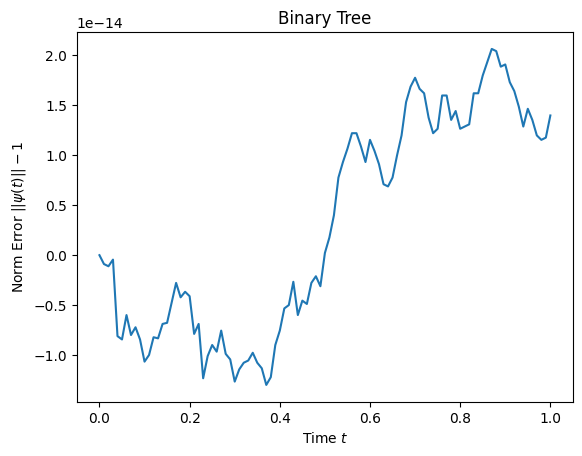

In [24]:
maximum_error = max(abs(norm_error))
print("Maximum Error:", maximum_error)
fig, ax = subplots()
ax.plot(times, norm_error)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Norm Error $||\psi(t)|| - 1$")
ax.set_title("Binary Tree")

show()

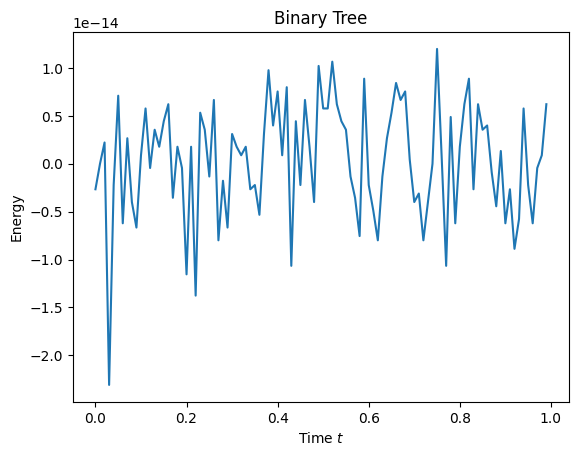

In [25]:
energy = binary_tree_bug.operator_result("energy", realise=True)
energy_difference = energy[:-1] - energy[1:]

fig, ax = subplots()
ax.plot(times[:-1], energy_difference)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Energy")
ax.set_title("Binary Tree")

show()

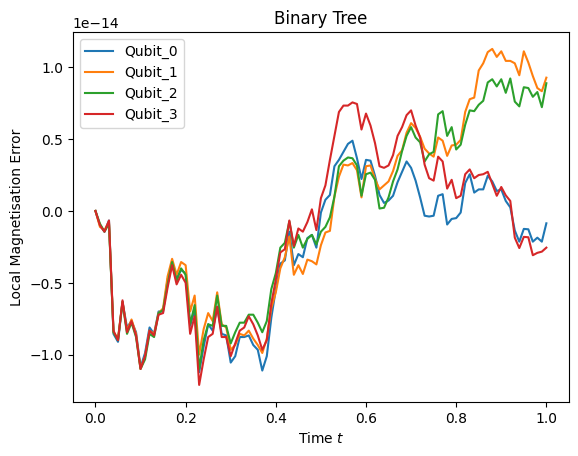

In [26]:
fig, ax = subplots()
for identifier in qubit_ids:
    local_magn = binary_tree_bug.operator_result(identifier, realise=True)
    exact_local_magn = exact_evo.operator_result(identifier, realise=True)
    magn_error = local_magn - exact_local_magn
    ax.plot(times, magn_error, label=identifier)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Local Magnetisation Error")
ax.legend()
ax.set_title("Binary Tree")

show()

In [27]:
print(binary_tree_bug.state.bond_dims())

{('Root', 'Middle 0'): 4, ('Root', 'Middle 1'): 4, ('Middle 0', 'Qubit_0'): 2, ('Middle 0', 'Qubit_1'): 2, ('Middle 1', 'Qubit_2'): 2, ('Middle 1', 'Qubit_3'): 2}


## Tucker Tensor

In [28]:
root_tensor = one_tensor.reshape([1,1,1,1,1])

qubit_tensors = deepcopy(ket_0_state).reshape([1,2])

print("Root Tensor Shape:", root_tensor.shape)
print("Qubit Tensor Shape:", qubit_tensors.shape)

tucker_ttns = TreeTensorNetworkState()
root_id = "Root"
root_node = Node(identifier=root_id)
tucker_ttns.add_root(root_node, root_tensor)

qubit_ids = [f"Qubit_{i}" for i in range(num_sites)]
for i in range(num_sites):
    qubit_node = Node(identifier=qubit_ids[i])
    tucker_ttns.add_child_to_parent(qubit_node,
                             deepcopy(qubit_tensors),
                             0,
                             root_id,
                             i)

NameError: name 'one_tensor' is not defined

In [748]:
tucker_ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham, tucker_ttns)

In [749]:
operators = local_magnetisation(qubit_ids)
operators["energy"] = tucker_ttno
operators["norm"] = TensorProduct({qubit_ids[0]: eye(local_dim)})

In [750]:
tucker_bug = BUG(tucker_ttns, tucker_ttno, time_step_size, final_time, operators, config=bug_config)
print(tucker_bug.state.bond_dims())

{('Root', 'Qubit_0'): 1, ('Root', 'Qubit_1'): 1, ('Root', 'Qubit_2'): 1, ('Root', 'Qubit_3'): 1}


In [751]:
tucker_bug.run()

100%|██████████| 101/101 [00:00<00:00, 121.09it/s]


### Tucker Tree: Plotting Results

In [752]:
times = tucker_bug.times()
print("The results are approximately real:", tucker_bug.results_real())

The results are approximately real: True


In [753]:
norm = tucker_bug.operator_result("norm", realise=True)
norm_error = norm - 1

Maximum Error: 1.3322676295501878e-15


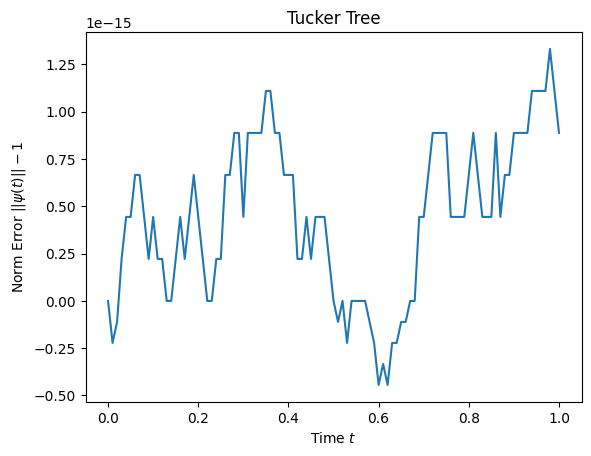

In [754]:
maximum_error = max(abs(norm_error))
print("Maximum Error:", maximum_error)
fig, ax = subplots()
ax.plot(times, norm_error)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Norm Error $||\psi(t)|| - 1$")
ax.set_title("Tucker Tree")

show()

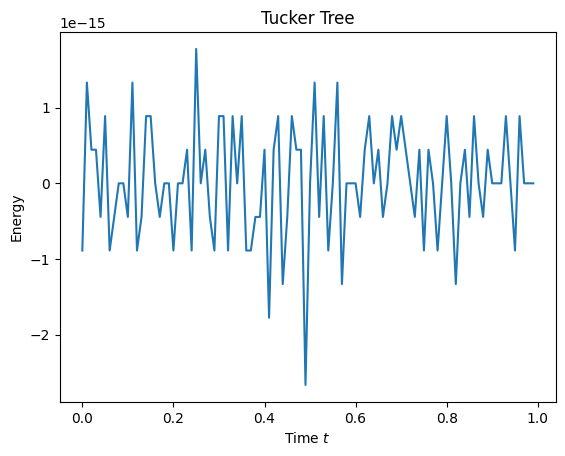

In [755]:
energy = tucker_bug.operator_result("energy", realise=True)
energy_difference = energy[:-1] - energy[1:]

fig, ax = subplots()
ax.plot(times[:-1], energy_difference)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Energy")
ax.set_title("Tucker Tree")

show()

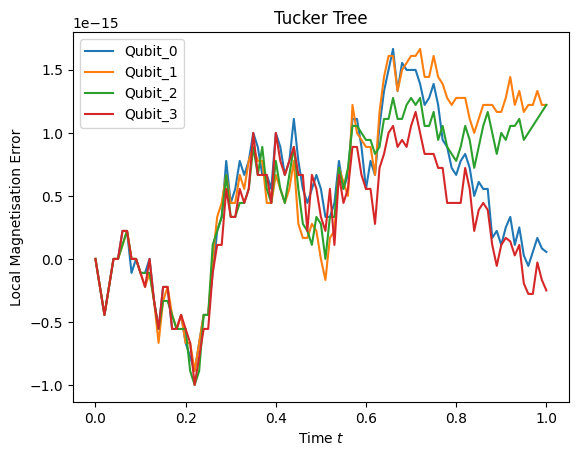

In [756]:
fig, ax = subplots()
for identifier in qubit_ids:
    local_magn = tucker_bug.operator_result(identifier, realise=True)
    exact_local_magn = exact_evo.operator_result(identifier, realise=True)
    magn_error = local_magn - exact_local_magn
    ax.plot(times, magn_error, label=identifier)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Local Magnetisation Error")
ax.legend()
ax.set_title("Tucker Tree")

show()

## MPS Tree

In [757]:
from pytreenet.special_ttn.mps import MatrixProductState

mps = MatrixProductState.constant_product_state(0, local_dim, num_sites,
                                                node_prefix="Qubit_",
                                                root_site=1,
                                                bond_dimensions=[2,2,2])
mps_ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham, mps)

In [758]:
operators = local_magnetisation(qubit_ids)
operators["energy"] = mps_ttno
operators["norm"] = TensorProduct({qubit_ids[0]: eye(local_dim)})

In [759]:
mps_bug = BUG(mps, mps_ttno, time_step_size, final_time, operators, config=bug_config)
print(mps_bug.state.bond_dims())

{('Qubit_1', 'Qubit_0'): 2, ('Qubit_1', 'Qubit_2'): 2, ('Qubit_2', 'Qubit_3'): 2}


In [760]:
mps_bug.run()

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:00<00:00, 129.85it/s]


### MPS: Plotting Results

In [761]:
times = mps_bug.times()
print("The results are approximately real:", mps_bug.results_real())

The results are approximately real: True


In [762]:
norm = mps_bug.operator_result("norm", realise=True)
norm_error = norm - 1

Maximum Error: 2.842170943040401e-14


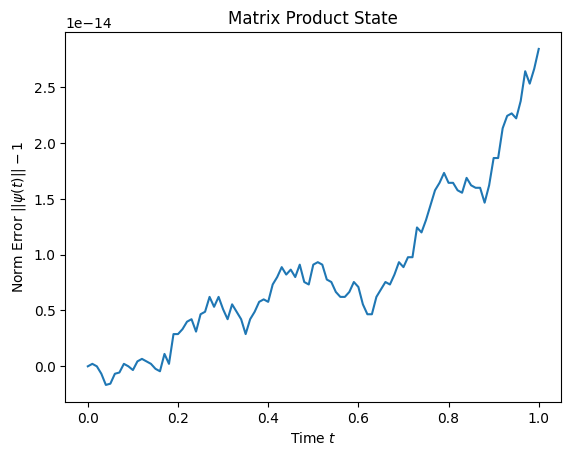

In [763]:
maximum_error = max(abs(norm_error))
print("Maximum Error:", maximum_error)
fig, ax = subplots()
ax.plot(times, norm_error)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Norm Error $||\psi(t)|| - 1$")
ax.set_title("Matrix Product State")

show()

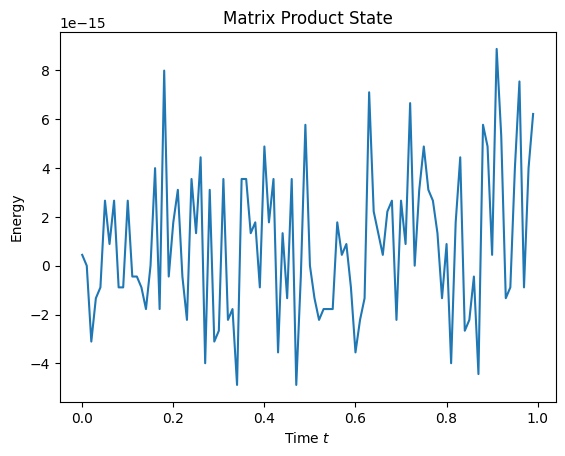

In [764]:
energy = mps_bug.operator_result("energy", realise=True)
energy_difference = energy[:-1] - energy[1:]

fig, ax = subplots()
ax.plot(times[:-1], energy_difference)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Energy")
ax.set_title("Matrix Product State")

show()

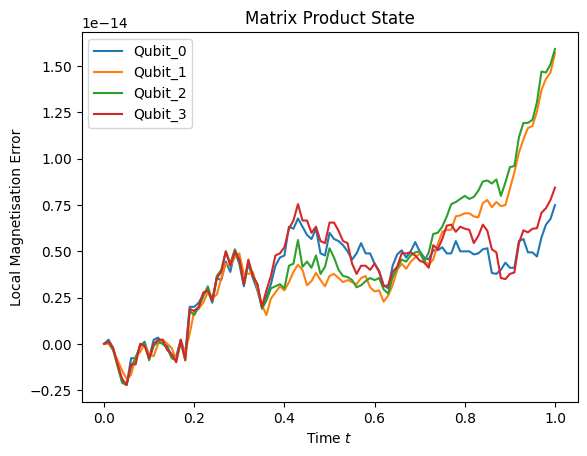

In [765]:
fig, ax = subplots()
for identifier in qubit_ids:
    local_magn = mps_bug.operator_result(identifier, realise=True)
    exact_local_magn = exact_evo.operator_result(identifier, realise=True)
    magn_error = local_magn - exact_local_magn
    ax.plot(times, magn_error, label=identifier)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Local Magnetisation Error")
ax.legend()
ax.set_title("Matrix Product State")

show()

In [766]:
print(mps_bug.state.bond_dims())

{('Qubit_1', 'Qubit_0'): 2, ('Qubit_1', 'Qubit_2'): 4, ('Qubit_2', 'Qubit_3'): 2}


## Star Tree

In [767]:
root_qubit = 2
root_id = qubit_ids[root_qubit]
root_tensor = zeros([1,1,1,2], dtype=complex)
root_tensor[0,0,0,:] = deepcopy(ket_0_state)

leaf_tensor = zeros([1,2], dtype=complex)
leaf_tensor[0,:] = deepcopy(ket_0_state)

print("Root Tensor Shape:", root_tensor.shape)
print("Leaf Tensor Shape:", leaf_tensor.shape)

star_ttns = TreeTensorNetworkState()
root_node = Node(identifier=root_id)
star_ttns.add_root(root_node, root_tensor)

for i in range(num_sites):
    if i != root_qubit:
        leaf_id = qubit_ids[i]
        leaf_node = Node(identifier=leaf_id)
        parent_leg = i - (i > root_qubit)
        star_ttns.add_child_to_parent(leaf_node,
                                      deepcopy(leaf_tensor),
                                      0,
                                      root_id,
                                      parent_leg)

Root Tensor Shape: (1, 1, 1, 2)
Leaf Tensor Shape: (1, 2)


In [768]:
star_ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham, star_ttns)

In [769]:
operators = local_magnetisation(qubit_ids)
operators["energy"] = star_ttno
operators["norm"] = TensorProduct({qubit_ids[0]: eye(local_dim)})

In [770]:
star_bug = BUG(star_ttns, star_ttno, time_step_size, final_time, operators, config=bug_config)
print(star_bug.state.bond_dims())

{('Qubit_2', 'Qubit_0'): 1, ('Qubit_2', 'Qubit_1'): 1, ('Qubit_2', 'Qubit_3'): 1}


In [771]:
star_bug.run()

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:00<00:00, 137.08it/s]


## Star: Plotting Results

In [772]:
times = star_bug.times()
print("The results are approximately real:", star_bug.results_real())

The results are approximately real: True


In [773]:
norm = star_bug.operator_result("norm", realise=True)
norm_error = norm - 1

Maximum Error: 1.3322676295501878e-15


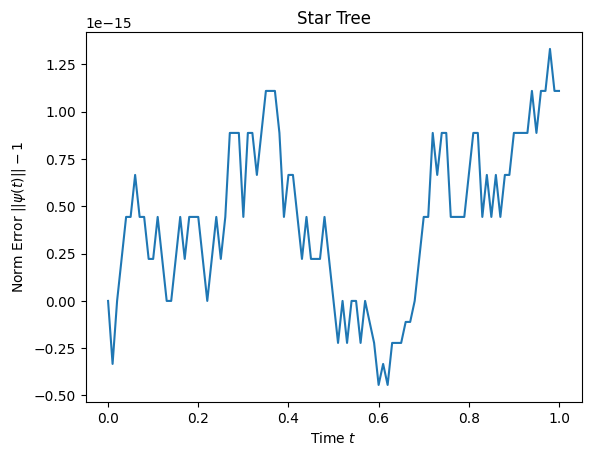

In [774]:
maximum_error = max(abs(norm_error))
print("Maximum Error:", maximum_error)
fig, ax = subplots()
ax.plot(times, norm_error)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Norm Error $||\psi(t)|| - 1$")
ax.set_title("Star Tree")

show()

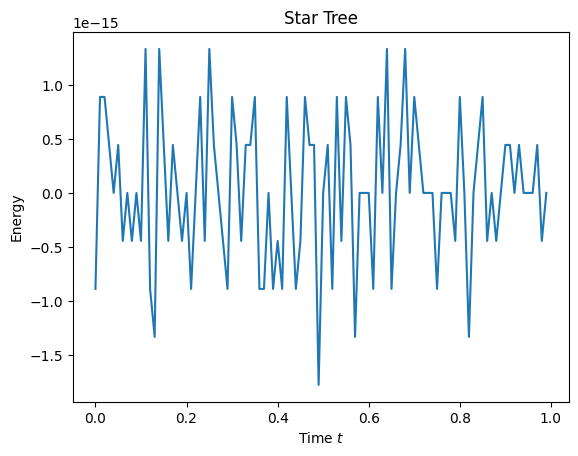

In [775]:
energy = star_bug.operator_result("energy", realise=True)
energy_difference = energy[:-1] - energy[1:]

fig, ax = subplots()
ax.plot(times[:-1], energy_difference)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Energy")
ax.set_title("Star Tree")

show()

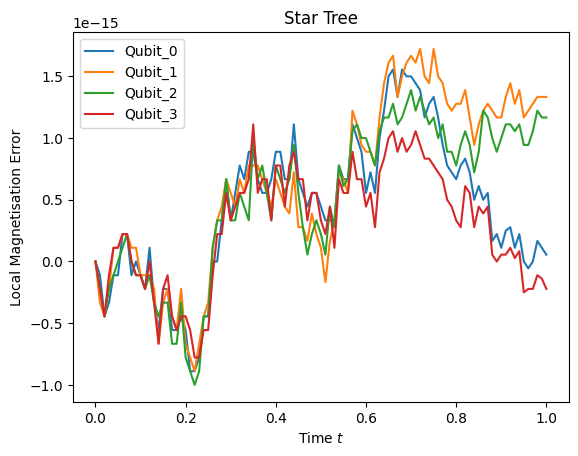

In [776]:
fig, ax = subplots()
for identifier in qubit_ids:
    local_magn = star_bug.operator_result(identifier, realise=True)
    exact_local_magn = exact_evo.operator_result(identifier, realise=True)
    magn_error = local_magn - exact_local_magn
    ax.plot(times, magn_error, label=identifier)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Local Magnetisation Error")
ax.legend()
ax.set_title("Star Tree")

show()

In [777]:
print(star_bug.state.bond_dims())

{('Qubit_2', 'Qubit_0'): 2, ('Qubit_2', 'Qubit_1'): 2, ('Qubit_2', 'Qubit_3'): 2}
